In [20]:
import pandas as pd
import numpy as np
import os
from IPython.display import IFrame
import folium
import seaborn as sns
import glob
import networkx as nx
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import shap

In [2]:
#location = '/Users/wentingjiang/Desktop/mda_kul_local/'
#file_name = 'df_model_v2.csv'
file_name = '../WentingJiang/data/processed/df_model_hourly.csv'

In [3]:
df_model = pd.read_csv(file_name)

In [5]:
df_model.columns

Index(['Unnamed: 0', 'timestamp', 'location', 'noise_level', 'event', 'count',
       'hour', 'day_of_week', 'humidity', 'temp', 'solar_radiation',
       'rain_intensity', 'daily_rain_sum', 'wind_dir', 'wind_speed',
       'LC_RAD60', 'LC_TEMP_QCL0', 'LC_TEMP_QCL1', 'LC_TEMP_QCL2',
       'LC_TEMP_QCL3', 'lat', 'lon', 'alt', 'climate_zone', 'green_cover',
       'building_height', 'sky_view_factor', 'installation_height', 'month',
       'day_of_month'],
      dtype='object')

In [6]:
df_model = df_model.drop(['Unnamed: 0', 'timestamp', 'count', 'LC_RAD60', 'LC_TEMP_QCL0', 'LC_TEMP_QCL1', 'LC_TEMP_QCL2', 'lat', 'lon', 'alt', 'climate_zone', 'month', 'day_of_month', 'hour'], axis=1)

In [7]:
all_locations = list(set(df_model.location))
all_locations

['MP 05: Calvariekapel KU Leuven',
 'MP 01: Naamsestraat 35  Maxim',
 'MP 06: Parkstraat 2 La Filosovia',
 'MP 03: Naamsestraat 62 Taste',
 'MP 02: Naamsestraat 57 Xior',
 'MP 07: Naamsestraat 81']

In [8]:
#df_model_small = df_model[df_model['location']==loc_name].drop('location', axis=1)
df_model_small = df_model.drop('location', axis=1)
X = df_model_small.drop("noise_level", axis=1)
X = pd.get_dummies(X)
y = np.array(df_model_small['noise_level'])

In [12]:
# for loc_name in all_locations:
#     df_model_small = df_model[df_model['location']==loc_name].drop('location', axis=1)
#     X = df_model_small.drop("noise_level", axis=1)
#     X = pd.get_dummies(X)
#     y = np.array(df_model_small['noise_level'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

In [14]:
# fit the model across all locations

In [10]:
# Create a random forest regression model
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

In [11]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Squared Error: 49.32860170698673
R-squared: 0.34605321763918784


Text(0, 0.5, 'predicted')

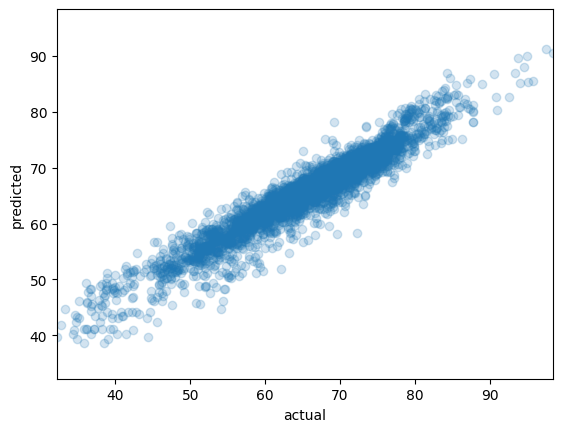

In [12]:
plt.scatter(y_train,regressor.predict(X_train), alpha=0.2)
lim_min = min(min(y_train), min(regressor.predict(X_train)))
lim_max = max(max(y_train), max(regressor.predict(X_train)))

plt.xlim([lim_min,lim_max])
plt.ylim([lim_min,lim_max])
plt.xlabel('actual')
plt.ylabel('predicted')

In [21]:
# plt.scatter(y_train,y_pred, alpha=0.2)
# lim_min = min(min(y_test), min(y_pred))
# lim_max = max(max(y_test), max(y_pred))

# plt.xlim([lim_min,lim_max])
# plt.ylim([lim_min,lim_max])
# plt.xlabel('actual')
# plt.ylabel('predicted')

In [13]:
regressor_full = RandomForestRegressor(n_estimators=100, random_state=0)
regressor_full.fit(X, y)

RandomForestRegressor(random_state=0)

In [21]:
# Generate SHAP values for your model
explainer = shap.Explainer(regressor_full)
shap_values = explainer.shap_values(X)

AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [24]:
shap_values = pd.DataFrame(shap_values)
shap_values.columns = list(X.columns)
location_and_explaination = pd.concat([df_model[['location']], shap_values], axis=1)

In [25]:
location_and_explaination.head()

,location,count,hour,humidity,temp,solar_radiation,rain_intensity,daily_rain_sum,wind_dir,wind_speed,...,event_Transport road - Passenger car,event_Transport road - Siren,event_Unsupported,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,MP 01: Naamsestraat 35 Maxim,-0.371046,0.070106,-0.344303,0.380471,0.003694,0.015302,-0.054021,-0.291470,-0.535975,...,0.002265,0.000101,0.000029,0.041997,-0.119023,-0.019108,0.004109,0.045290,-0.023496,0.125073
1,MP 01: Naamsestraat 35 Maxim,-0.361820,-0.381931,-0.017054,0.404229,0.002208,0.027616,-0.059467,0.513426,-0.334157,...,0.002457,0.000114,-0.000011,0.110983,-0.232464,-0.007726,0.000391,0.076765,-0.028337,0.054550
2,MP 01: Naamsestraat 35 Maxim,-0.390574,-2.898191,-0.228378,0.106717,0.002281,0.004829,-0.057231,0.376838,-0.672332,...,0.002503,0.000113,-0.000015,0.093031,-0.215535,0.012809,0.029877,-0.049967,-0.042004,0.000968
3,MP 01: Naamsestraat 35 Maxim,-0.405441,-3.642438,-0.261996,0.036375,0.002975,0.001419,-0.059713,0.803160,-0.582107,...,0.002558,0.000114,0.000057,0.138165,-0.241991,-0.000610,0.027223,-0.061757,-0.048099,0.012156
4,MP 01: Naamsestraat 35 Maxim,-0.271609,1.887412,0.114899,0.072763,0.016673,0.007578,0.653147,0.320165,-0.063885,...,0.001820,0.000037,0.000241,0.009803,-0.068964,0.002685,-0.012362,0.002479,0.027945,0.038593


In [26]:
#location_and_explaination.to_csv('location_and_explaination.csv')

In [29]:
shap_df = pd.concat([df_model[['timestamp']], location_and_explaination], axis=1)
shap_df.head()

,timestamp,location,count,hour,humidity,temp,solar_radiation,rain_intensity,daily_rain_sum,wind_dir,...,event_Transport road - Passenger car,event_Transport road - Siren,event_Unsupported,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,2022-01-03 00:00:00,MP 01: Naamsestraat 35 Maxim,-0.371046,0.070106,-0.344303,0.380471,0.003694,0.015302,-0.054021,-0.291470,...,0.002265,0.000101,0.000029,0.041997,-0.119023,-0.019108,0.004109,0.045290,-0.023496,0.125073
1,2022-01-03 01:00:00,MP 01: Naamsestraat 35 Maxim,-0.361820,-0.381931,-0.017054,0.404229,0.002208,0.027616,-0.059467,0.513426,...,0.002457,0.000114,-0.000011,0.110983,-0.232464,-0.007726,0.000391,0.076765,-0.028337,0.054550
2,2022-01-03 02:00:00,MP 01: Naamsestraat 35 Maxim,-0.390574,-2.898191,-0.228378,0.106717,0.002281,0.004829,-0.057231,0.376838,...,0.002503,0.000113,-0.000015,0.093031,-0.215535,0.012809,0.029877,-0.049967,-0.042004,0.000968
3,2022-01-03 03:00:00,MP 01: Naamsestraat 35 Maxim,-0.405441,-3.642438,-0.261996,0.036375,0.002975,0.001419,-0.059713,0.803160,...,0.002558,0.000114,0.000057,0.138165,-0.241991,-0.000610,0.027223,-0.061757,-0.048099,0.012156
4,2022-01-03 17:00:00,MP 01: Naamsestraat 35 Maxim,-0.271609,1.887412,0.114899,0.072763,0.016673,0.007578,0.653147,0.320165,...,0.001820,0.000037,0.000241,0.009803,-0.068964,0.002685,-0.012362,0.002479,0.027945,0.038593


In [38]:
import pandas as pd

# Assuming you have a DataFrame with a column named 'date_column' containing dates as strings

# Convert the column to datetime
shap_df['timestamp'] = pd.to_datetime(shap_df['timestamp'])

# Format the datetime column as 'dd/mm/yy hh:mm'
shap_df['formatted_date'] = shap_df['timestamp'].dt.strftime('%d/%m/%y %H:%M')
shap_final =shap_df.drop('timestamp', axis=1)
shap_final.head()

,location,count,hour,humidity,temp,solar_radiation,rain_intensity,daily_rain_sum,wind_dir,wind_speed,...,event_Transport road - Siren,event_Unsupported,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,formatted_date
0,MP 01: Naamsestraat 35 Maxim,-0.371046,0.070106,-0.344303,0.380471,0.003694,0.015302,-0.054021,-0.291470,-0.535975,...,0.000101,0.000029,0.041997,-0.119023,-0.019108,0.004109,0.045290,-0.023496,0.125073,03/01/22 00:00
1,MP 01: Naamsestraat 35 Maxim,-0.361820,-0.381931,-0.017054,0.404229,0.002208,0.027616,-0.059467,0.513426,-0.334157,...,0.000114,-0.000011,0.110983,-0.232464,-0.007726,0.000391,0.076765,-0.028337,0.054550,03/01/22 01:00
2,MP 01: Naamsestraat 35 Maxim,-0.390574,-2.898191,-0.228378,0.106717,0.002281,0.004829,-0.057231,0.376838,-0.672332,...,0.000113,-0.000015,0.093031,-0.215535,0.012809,0.029877,-0.049967,-0.042004,0.000968,03/01/22 02:00
3,MP 01: Naamsestraat 35 Maxim,-0.405441,-3.642438,-0.261996,0.036375,0.002975,0.001419,-0.059713,0.803160,-0.582107,...,0.000114,0.000057,0.138165,-0.241991,-0.000610,0.027223,-0.061757,-0.048099,0.012156,03/01/22 03:00
4,MP 01: Naamsestraat 35 Maxim,-0.271609,1.887412,0.114899,0.072763,0.016673,0.007578,0.653147,0.320165,-0.063885,...,0.000037,0.000241,0.009803,-0.068964,0.002685,-0.012362,0.002479,0.027945,0.038593,03/01/22 17:00


In [42]:
shap_final.rename(columns={'count': 'noise_events_count'}, inplace=True)
shap_final.to_csv('shap_final.csv')

In [40]:
shap_final.head()

,location,noise_events_count,hour,humidity,temp,solar_radiation,rain_intensity,daily_rain_sum,wind_dir,wind_speed,...,event_Transport road - Siren,event_Unsupported,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,formatted_date
0,MP 01: Naamsestraat 35 Maxim,-0.371046,0.070106,-0.344303,0.380471,0.003694,0.015302,-0.054021,-0.291470,-0.535975,...,0.000101,0.000029,0.041997,-0.119023,-0.019108,0.004109,0.045290,-0.023496,0.125073,03/01/22 00:00
1,MP 01: Naamsestraat 35 Maxim,-0.361820,-0.381931,-0.017054,0.404229,0.002208,0.027616,-0.059467,0.513426,-0.334157,...,0.000114,-0.000011,0.110983,-0.232464,-0.007726,0.000391,0.076765,-0.028337,0.054550,03/01/22 01:00
2,MP 01: Naamsestraat 35 Maxim,-0.390574,-2.898191,-0.228378,0.106717,0.002281,0.004829,-0.057231,0.376838,-0.672332,...,0.000113,-0.000015,0.093031,-0.215535,0.012809,0.029877,-0.049967,-0.042004,0.000968,03/01/22 02:00
3,MP 01: Naamsestraat 35 Maxim,-0.405441,-3.642438,-0.261996,0.036375,0.002975,0.001419,-0.059713,0.803160,-0.582107,...,0.000114,0.000057,0.138165,-0.241991,-0.000610,0.027223,-0.061757,-0.048099,0.012156,03/01/22 03:00
4,MP 01: Naamsestraat 35 Maxim,-0.271609,1.887412,0.114899,0.072763,0.016673,0.007578,0.653147,0.320165,-0.063885,...,0.000037,0.000241,0.009803,-0.068964,0.002685,-0.012362,0.002479,0.027945,0.038593,03/01/22 17:00


In [41]:
locations = list(shap_final.location)
for loc in locations:
    temp = shap_final[shap_final['location']==loc]
    temp.to_csv(loc + '.csv')